# Setup

In [ ]:
!pip -q install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 28.1 MB/s eta 0:00:00


# ENV

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split

import numpy as np
import pandas as pd
import lightning as L

from einops.layers.torch import Rearrange, Reduce
from einops import reduce, rearrange, repeat, einsum, parse_shape, pack, unpack

In [ ]:
import seaborn as sns
sns.set()

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['lines.linewidth']=2

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')

In [ ]:
seed=42
L.seed_everything(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False
device='cuda' if torch.cuda.is_available() else 'cpu'
device

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


'cpu'

# Data

In [ ]:
from torchvision import transforms
from torchvision.datasets import CIFAR10
from collections import Counter

class DataModule(L.LightningDataModule):
    def __init__(self, batch_size=32):
        super().__init__()
        self.batch_size=batch_size
        self.transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

        self.image_size=[3,32,32]
        self.num_classes=10

    def prepare_data(self):
        pass

    def setup(self, stage=None):
        if stage=='fit' or stage is None:
            dataset=CIFAR10('.', download=True, train=True, transform=self.transform)
            self.train, self.val = random_split(dataset, [49000, 1000])
        if stage=='test' or stage is None:
            self.test=CIFAR10('.', download=True, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, shuffle=True, drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, shuffle=False, drop_last=True)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, shuffle=False, drop_last=True)

tmp=DataModule(128)
tmp.setup()
batch=next(iter(tmp.train_dataloader()))
print(len(batch))
print(batch[0].shape)
print(batch[1].shape)

100%|██████████| 170498071/170498071 [00:05<00:00, 29317737.34it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified
2
torch.Size([128, 3, 32, 32])
torch.Size([128])


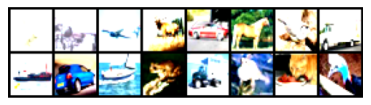

In [ ]:
from torchvision.utils import make_grid

def show_image(images, num_images, image_size=[3,32,32]):
    images=images.detach().cpu()
    grid_image=make_grid(images[:num_images], nrow=8)
    plt.imshow(grid_image.permute(1,2,0))
    plt.axis('off')
    plt.show()

show_image(batch[0],16)

# Architecture

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels=-1, sub_sample=False):
        super().__init__()
        if not sub_sample:
            out_channels=in_channels

        self.layer = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1 if not sub_sample else 2),
                                   nn.BatchNorm2d(out_channels),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(out_channels))

        self.downsample=nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2) if sub_sample else nn.Identity()

    def forward(self, x):
        return F.relu(self.downsample(x)+self.layer(x), inplace=True)

x=torch.rand([7,3,32,32])
tmp=ResBlock(3,3,sub_sample=True)
tmp(x).shape

torch.Size([7, 3, 16, 16])

In [ ]:
class PreActResBlock(nn.Module):
    def __init__(self, in_channels, out_channels=-1, sub_sample=False):
        super().__init__()
        if not sub_sample:
            out_channels=in_channels

        self.layer = nn.Sequential(nn.BatchNorm2d(in_channels),
                                 nn.ReLU(inplace=True),
                                 nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1 if not sub_sample else 2),
                                 nn.BatchNorm2d(out_channels),
                                 nn.ReLU(inplace=True),
                                 nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))

        self.downsample=nn.Sequential(nn.BatchNorm2d(in_channels),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2)) if sub_sample else nn.Identity()

    def forward(self, x):
        return self.downsample(x)+self.layer(x)

x=torch.rand(7,3,32,32)
tmp=PreActResBlock(3,6,sub_sample=True)
tmp(x).shape

torch.Size([7, 6, 16, 16])

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_classes, input_channels, hidden_channels, num_blocks, block_type=PreActResBlock):
        super().__init__()

        if block_type==PreActResBlock:
            self.up_sample = nn.Conv2d(3, hidden_channels[0], kernel_size=3, padding=1)
        else:
            self.up_sample = nn.Sequential(nn.Conv2d(input_channels, hidden_channels[0], kernel_size=3, padding=1),
                                           nn.BatchNorm3d(hidden_channels[0]),
                                           nn.ReLU(inplace=True))

        blocks=[]
        for block_idx, num_layers in enumerate(num_blocks):
            for layer_idx in range(num_layers):
                sub_sample = (layer_idx==0) and (block_idx!=0)
                blocks.append(block_type(in_channels=hidden_channels[block_idx if not sub_sample else block_idx-1],
                                        out_channels=hidden_channels[block_idx],sub_sample=sub_sample))

        self.blocks=nn.Sequential(*blocks)
        self.head=nn.Sequential(nn.AvgPool2d([1,1]),
                                nn.Flatten(),
                                nn.Linear(hidden_channels[-1], num_classes))

    def forward(self, x):
        x=self.up_sample(x)
        x=self.blocks(x)
        x=self.head(x)
        return x

x=torch.rand(7,3,32,32)
tmp=ResNet(num_classes=10, input_channels=3, hidden_channels=[12, 16, 24, 32, 48, 64], num_blocks=[3, 3,3,3,3,3])
tmp(x).shape

torch.Size([7, 10])

# Training

In [ ]:
class Training(L.LightningModule):
    def __init__(self, num_classes, input_channels, hidden_channels, num_blocks, lr, momentum, weight_decay):
        super().__init__()
        self.save_hyperparameters()
        # self.automatic_optimization=False
        self.model=ResNet(num_classes, input_channels, hidden_channels, num_blocks)
        self.example_input_array = torch.zeros([1, 3, 32, 32], dtype=torch.float32)

    def criterion(self, pred, y):
        loss = F.cross_entropy(pred,y)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.model.parameters(), lr=self.hparams.lr, momentum=self.hparams.momentum, weight_decay=self.hparams.weight_decay)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
        # SGD is better than Adam for ResNet https://arxiv.org/pdf/1712.09913
        return [optimizer],[scheduler]

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch):
        imgs, labels = batch
        pred = self.model(imgs)
        loss=self.criterion(pred, labels)
        acc = (pred.argmax(dim=-1) == labels).float().mean()

        self.log('train_acc', acc, prog_bar=True)
        self.log('train_loss', loss, prog_bar=True)

        return loss

    def validation_step(self, batch):
        imgs, labels=batch
        pred=self.model(imgs)
        loss=self.criterion(pred,labels)
        acc=(pred.argmax(dim=-1)==labels).float().mean()

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def test_step(self, batch):
        imgs, labels=batch
        pred=self.model(imgs)
        loss=self.criterion(pred,labels)
        acc=(pred.argmax(dim=-1)==labels).float().mean()

        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)


In [ ]:
data_module=DataModule(128)
training=Training(10,3, [12, 16, 24, 32, 48, 64], [3, 3,3,3,3,3], 1e-3, 0.9 , 1e-4)
trainer = L.Trainer(accelerator='auto',
                    devices=1,
                    max_epochs=50)
trainer.fit(training,data_module)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified


INFO: 
  | Name  | Type   | Params | Mode  | In sizes       | Out sizes
----------------------------------------------------------------------
0 | model | ResNet | 443 K  | train | [1, 3, 32, 32] | [1, 10]  
----------------------------------------------------------------------
443 K     Trainable params
0         Non-trainable params
443 K     Total params
1.775     Total estimated model params size (MB)
184       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type   | Params | Mode  | In sizes       | Out sizes
----------------------------------------------------------------------
0 | model | ResNet | 443 K  | train | [1, 3, 32, 32] | [1, 10]  
----------------------------------------------------------------------
443 K     Trainable params
0         Non-trainable params
443 K     Total params
1.775     Total estimated model params size (MB)
184       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO: 
Detected KeyboardInterrupt, attempting graceful shutdown ...
INFO:lightning.pytorch.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined